In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from math import ceil, log2
import category_encoders as ce

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

CV_verbose_param = 1

In [27]:
dataset = pd.read_csv('datasets/spotify_tracks_cleaned.csv')
dataset.head()

,artists,album_name,track_name,duration_ms,explicit,danceability,energy,key,loudness,mode,...,GENRE_spanish,GENRE_study,GENRE_swedish,GENRE_synth-pop,GENRE_tango,GENRE_techno,GENRE_trance,GENRE_trip-hop,GENRE_turkish,GENRE_world-music
0,Rill,Lolly,Lolly,160725,True,0.910,0.374,8,-9.844,0,...,0,0,0,0,0,0,0,0,0,0
1,Glee Cast,Glee Love Songs,It's All Coming Back To Me Now (Glee Cast Vers...,322933,False,0.269,0.516,0,-7.361,1,...,0,0,0,0,0,0,0,0,0,0
2,Paul Kalkbrenner;Pig&Dan,X,Böxig Leise - Pig & Dan Remix,515360,False,0.686,0.560,5,-13.264,0,...,0,0,0,0,0,0,0,0,0,0
3,Jordan Sandhu,Teeje Week,Teeje Week,190203,False,0.679,0.770,0,-3.537,1,...,0,0,0,0,0,0,0,0,0,0
4,Paul Kalkbrenner,Zeit,Tief,331240,False,0.519,0.431,6,-13.606,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
X = dataset.drop(columns=['popularity'])    # features
y = dataset['popularity']                   # target variable

#### Categorical features encoding

**mode** and **GENRE_{genre_name}** are binary categorical feature already mapped in {0,1}

**explicit** is a binary categorical feature that we map in {0,1}

In [29]:
X['explicit'] = X['explicit'].map({False : 0, True : 1})

**key** and **time_signature** are categorical features on which we apply one-hot encoding

In [30]:
features = ['key', 'time_signature']

ohe = ce.OneHotEncoder(cols=features) 
X = ohe.fit_transform(X)

for f in features:
    print(f'{dataset[f].nunique():>4} columns used to one-hot encode {f}')

  12 columns used to one-hot encode key
   5 columns used to one-hot encode time_signature


**artists**, **album_name** and **track_name** are categorical features with a large number of distinct values on which we apply binary encoding

In [31]:
features = ['artists', 'album_name', 'track_name']

be = ce.BinaryEncoder(cols=features)
X = be.fit_transform(X)

for f in features:
    print(f'{ceil(log2(dataset[f].nunique())):>4} columns used to binary encode {f}')

  15 columns used to binary encode artists
  16 columns used to binary encode album_name
  17 columns used to binary encode track_name


In [32]:
X['popularity_subsamples'] = y.map(lambda x: x if x % 2 == 0 else x+1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X['popularity_subsamples'])

X_train.drop(columns='popularity_subsamples', inplace=True)
X_test.drop(columns='popularity_subsamples', inplace=True)

In [33]:
X_train['mode'].corr(y_train)

-0.014134122062802425

In [34]:
X_train['explicit'].corr(y_train)

0.05345766099560088

In [35]:
worst_features = ['tempo', 'liveness']
X_train.drop(columns=worst_features, inplace=True)
X_test.drop(columns=worst_features, inplace=True)

### Features normalization

In [36]:
standard_scaler = preprocessing.StandardScaler().set_output(transform="pandas")

X_train = standard_scaler.fit_transform(X_train)
X_test = standard_scaler.transform(X_test)

## *Ridge Regression* on *Spotify Tracks Dataset*

In [37]:
from ridge_regression import RR

### Hyper-parameters tuning

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best hyper-param is λ = 141.95833333333331 with a score of -257.52616491951846


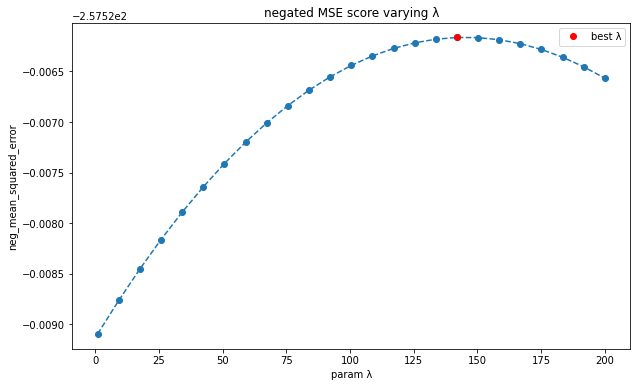

In [38]:
λ_grid = np.linspace(1, 200, num=25)

learner = GridSearchCV(estimator=RR(), n_jobs=-1, param_grid={'λ': λ_grid}, scoring='neg_mean_squared_error', cv=5, verbose=CV_verbose_param)
learner.fit(X_train, y_train)

print(f'Best hyper-param is λ = {learner.best_params_["λ"]} with a score of {learner.best_score_}')

fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(6)
ax.plot(learner.cv_results_['param_λ'].data, learner.cv_results_['mean_test_score'], linestyle='--', marker='o')
ax.plot(learner.best_params_['λ'], learner.best_score_, 'ro', label="best λ") 
ax.set(xlabel='param λ', ylabel='neg_mean_squared_error', title='negated MSE score varying λ')
plt.legend()
plt.show()

In [39]:
def print_performance(y_test, y_prediction):
    print('MSE :', mean_squared_error(y_test, y_prediction))
    print(' R2 :', r2_score(y_test, y_prediction))

In [40]:
rr = learner.best_estimator_
rr.fit(X_train, y_train)
y_prediction = rr.predict(X_test)

print_performance(y_test, y_prediction)

MSE : 258.8116521617912
 R2 : 0.38758236469114427


In [41]:
def residuals_analysis(y_test, y_prediction):
    
    residuals = y_test - y_prediction

    q1 = np.quantile(residuals, 0.25)
    q2 = np.quantile(residuals, 0.5)
    q3 = np.quantile(residuals, 0.75)
    iqr = q3 - q1

    print(f'q1          : {q1}')
    print(f'q2 (median) : {q2}')
    print(f'q3          : {q3}')
    print(f'IQR         : {iqr}')

    fig, ax = plt.subplots()
    fig.set_figwidth(8)
    fig.set_figheight(5)
    n, _, _  = ax.hist(residuals, density=True, bins=100)
    plt.errorbar(q2, max(n) + 0.002, xerr = [[q2-q1],[q3-q2]], fmt ='o', label="IQR") 
    plt.xlabel("residual (test - prediction)")
    plt.ylabel("relative frequency")
    plt.title("Density plot of the residuals")
    plt.legend()
    plt.show()

q1          : -8.847715376293849
q2 (median) : -1.0084816245305248
q3          : 8.560314830228345
IQR         : 17.40803020652219


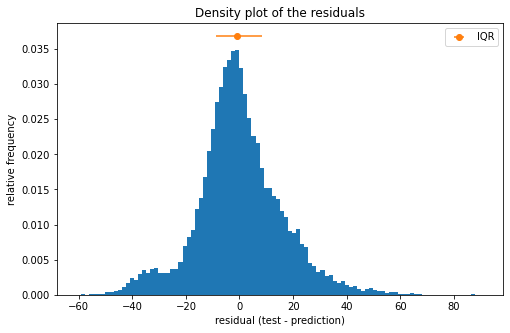

In [42]:
residuals_analysis(y_test, y_prediction)

## *Kernel Ridge Regression* on *Spotify Tracks Dataset*

Warning : some of the cells below will take 2-3 minutes to run

In [43]:
from kernel_ridge_regression import KRR

We run KRR just on samples of the dataset because, otherwise, it would get too computationally expensive 

In [44]:
train_sample_size = 5000
test_sample_size = 1000

X_train_sample = X_train.sample(n=train_sample_size, random_state=1)
y_train_sample = pd.Series(data = [y_train[i] for i in X_train_sample.index], index = X_train_sample.index)

X_test_sample = X_test.sample(n=test_sample_size, random_state=1)
y_test_sample = pd.Series(data = [y_test[i] for i in X_test_sample.index], index = X_test_sample.index)

### Hyper-parameters tuning

In [45]:
all_experiments = True

Fitting 5 folds for each of 25 candidates, totalling 125 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best hyper-params are λ = 0.01 and γ = 1000.0 with a score of -257.26498169284554


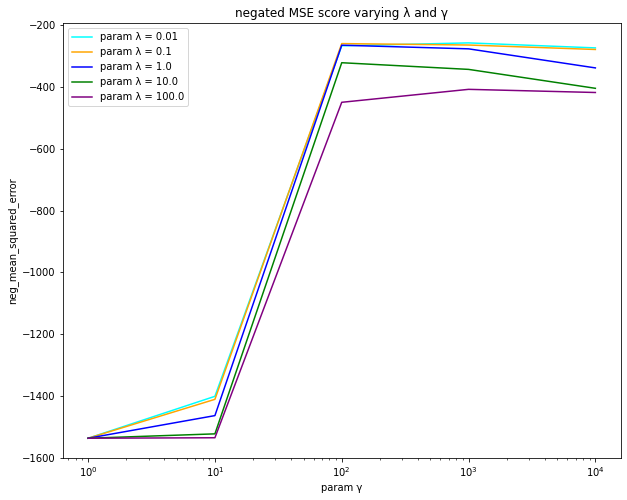

In [46]:
if all_experiments:
    
    λ_grid = 10. ** np.arange(-2, 3) 
    γ_grid = 10. ** np.arange(0, 5) 

    learner = GridSearchCV(estimator=KRR(), n_jobs=-1, param_grid={'λ': λ_grid, 'γ': γ_grid}, scoring='neg_mean_squared_error', cv=5, verbose=CV_verbose_param)
    learner.fit(X_train_sample, y_train_sample)

    print(f'Best hyper-params are λ = {learner.best_params_["λ"]} and γ = {learner.best_params_["γ"]} with a score of {learner.best_score_}')

    score = learner.cv_results_['mean_test_score']

    dict_λ = {}
    for v in set(learner.cv_results_['param_λ'].data):
        dict_λ[v] = (sorted(set(learner.cv_results_['param_γ'].data)), [])
    for i, p in enumerate(learner.cv_results_['params']):
        dict_λ[p['λ']][1].append(score[i])

    fig, ax = plt.subplots()
    fig.set_figwidth(10)
    fig.set_figheight(8)

    colors = ['purple', 'green', 'blue', 'orange', 'cyan']
    for k in sorted(dict_λ.keys()):
        ax.plot(dict_λ[k][0], dict_λ[k][1], label = f"param λ = {k}", linestyle="-", color = colors.pop())

    ax.set(xscale='log', xlabel='param γ', ylabel='neg_mean_squared_error', title='negated MSE score varying λ and γ')
    plt.legend()
    plt.show()

In the following search we restrict the candidate values for the hyper-parameters 

Fitting 5 folds for each of 21 candidates, totalling 105 fits
Best hyper-params are λ = 0.1 and γ = 300 with a score of -254.07596540147637


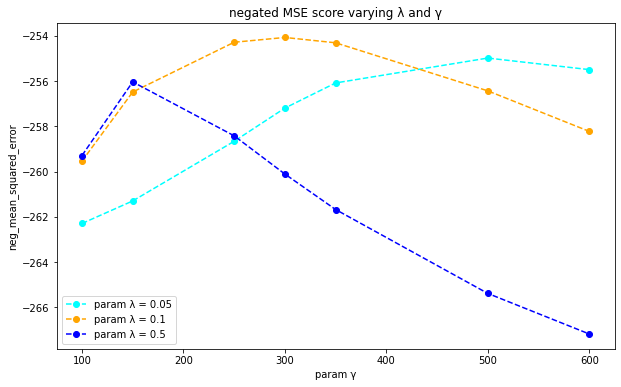

In [47]:
λ_grid = [0.05, 0.1, 0.5]
γ_grid = [100, 150, 250, 300, 350, 500, 600]

learner = GridSearchCV(estimator=KRR(), n_jobs=-1, param_grid={'λ': λ_grid, 'γ': γ_grid}, scoring='neg_mean_squared_error', cv=5, verbose=CV_verbose_param)
learner.fit(X_train_sample, y_train_sample)

print(f'Best hyper-params are λ = {learner.best_params_["λ"]} and γ = {learner.best_params_["γ"]} with a score of {learner.best_score_}')

score = learner.cv_results_['mean_test_score']
dict_λ = {}
for v in set(learner.cv_results_['param_λ'].data):
    dict_λ[v] = (sorted(set(learner.cv_results_['param_γ'].data)), [])
for i, p in enumerate(learner.cv_results_['params']):
    dict_λ[p['λ']][1].append(score[i])

fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(6)

colors = ['purple', 'green', 'blue', 'orange', 'cyan']
for k in sorted(dict_λ.keys()):
    ax.plot(dict_λ[k][0], dict_λ[k][1], label = f"param λ = {k}", linestyle='--', marker='o', color = colors.pop())

ax.set(xlabel='param γ', ylabel='neg_mean_squared_error', title='negated MSE score varying λ and γ')
plt.legend()
plt.show()

In [48]:
train_sample_size_BIG = 20000
test_sample_size_BIG = 4000

X_train_sample_BIG = X_train.sample(n=train_sample_size_BIG, random_state=1)
y_train_sample_BIG = pd.Series(data = [y_train[i] for i in X_train_sample_BIG.index], index = X_train_sample_BIG.index)

X_test_sample_BIG = X_test.sample(n=test_sample_size_BIG, random_state=1)
y_test_sample_BIG = pd.Series(data = [y_test[i] for i in X_test_sample_BIG.index], index = X_test_sample_BIG.index)

In [49]:
krr = learner.best_estimator_
krr.fit(X_train_sample_BIG, y_train_sample_BIG)
y_prediction = krr.predict(X_test_sample_BIG)

print_performance(y_test_sample_BIG, y_prediction)

MSE : 204.32800130580722
 R2 : 0.4936165584737332


q1          : -7.431183085058938
q2 (median) : -0.760729920665657
q3          : 7.295378996361556
IQR         : 14.726562081420495


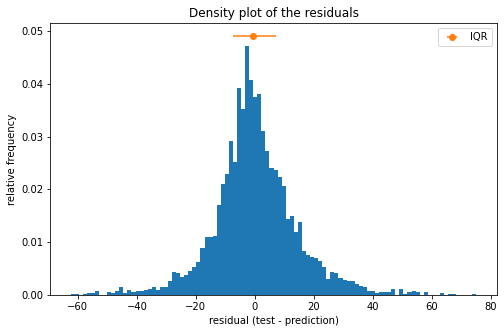

In [50]:
residuals_analysis(y_test_sample_BIG, y_prediction)